In [39]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [40]:
df = pd.read_csv("data/hole_card_data.csv")

df['suited'] = pd.Categorical(df['suited'], ordered=False)
df['pair'] = pd.Categorical(df['pair'], ordered=False)

In [43]:
embedding_dim = 8
embedder = nn.Embedding(169, embedding_dim)
embedder.load_state_dict(torch.load('hand_embedding_weights/model1/embeddings.pt', 
                                     weights_only=True))

<All keys matched successfully>

In [44]:
with torch.no_grad():
    all_indices = torch.arange(169, dtype=torch.long)
    embeddings = embedder(all_indices).numpy()

### Distribution of Embeddings

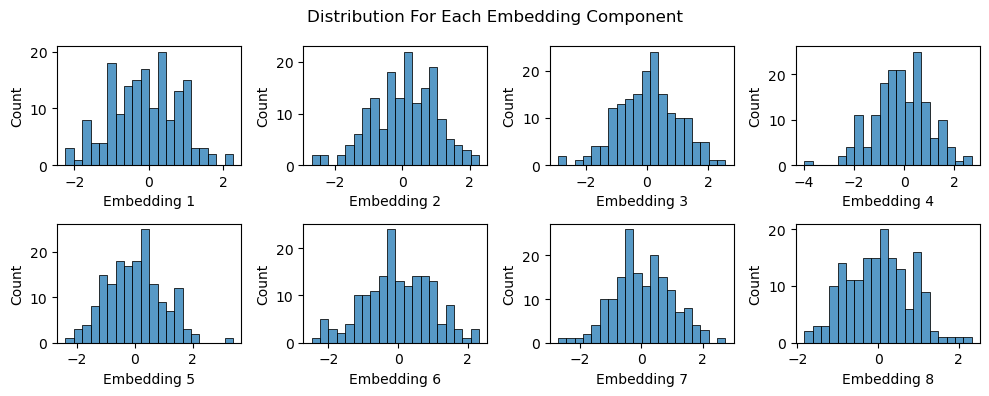

In [45]:
fig, axes = plt.subplots(2, 4, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df, x=embeddings[:, i], ax=ax, bins=20)
    ax.set_xlabel(f'Embedding {i+1}')
fig.suptitle("Distribution For Each Embedding Component")
plt.tight_layout()
plt.show()

### Correlation of Embeddings

In [46]:
print("Correlation between River Win Rate and Embedding Components")
for emb_idx in range(embedding_dim):
    corr = np.corrcoef(df['river_win_rate'].to_numpy(), embeddings[:,emb_idx])[0,1]
    print(f"--- Embedding {emb_idx+1}: {round(corr,4)}")

Correlation between River Win Rate and Embedding Components
--- Embedding 1: -0.0978
--- Embedding 2: -0.0474
--- Embedding 3: 0.0314
--- Embedding 4: 0.156
--- Embedding 5: -0.0238
--- Embedding 6: 0.0512
--- Embedding 7: 0.0113
--- Embedding 8: -0.2314


### t-SNE Visualization

In [47]:
suited_np = df['suited'].to_numpy()
pair_np = df['pair'].to_numpy()
connected_np = df['connectedness'].to_numpy()

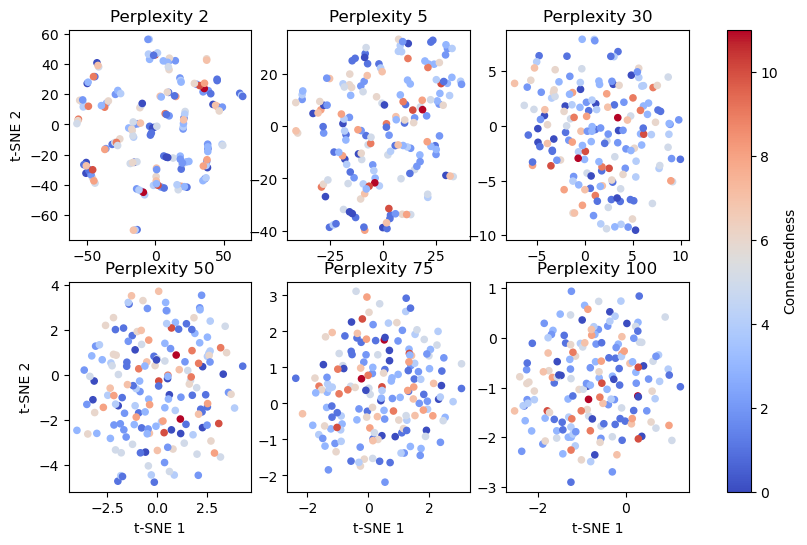

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
perplexities = [2, 5, 30, 50, 75, 100]
for idx, ax in enumerate(axes.flatten()):
    tsne = TSNE(n_components=2, random_state=29, perplexity=perplexities[idx])
    embeddings_2d_tsne = tsne.fit_transform(embeddings)
    
    scatter = ax.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1], s=20, c=connected_np, cmap='coolwarm')
    
    if idx in {0,3}:
        ax.set_ylabel('t-SNE 2')
    if idx >= 3:
        ax.set_xlabel('t-SNE 1')
        
    ax.set_title(f'Perplexity {perplexities[idx]}')

cbar = fig.colorbar(scatter, ax=axes)
cbar.set_label('Connectedness')
plt.show()

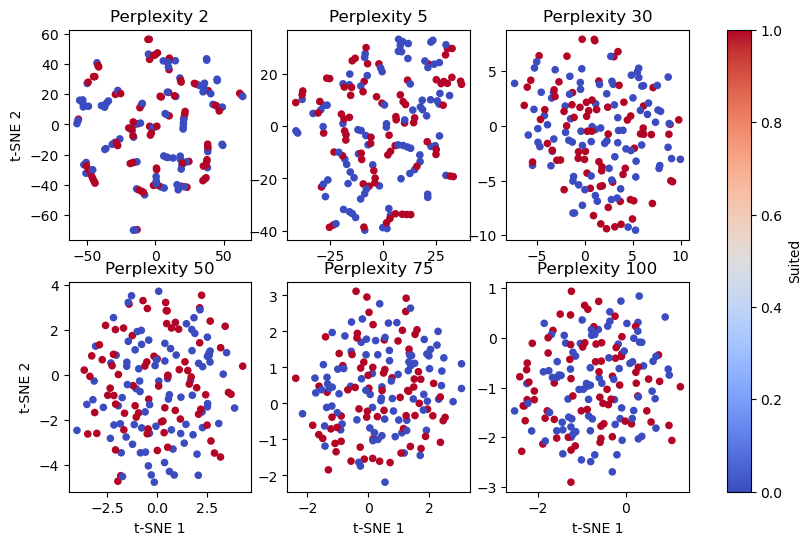

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
perplexities = [2, 5, 30, 50, 75, 100]
for idx, ax in enumerate(axes.flatten()):
    tsne = TSNE(n_components=2, random_state=29, perplexity=perplexities[idx])
    embeddings_2d_tsne = tsne.fit_transform(embeddings)
    
    scatter = ax.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1], s=20, c=suited_np, cmap='coolwarm')
    
    if idx in {0,3}:
        ax.set_ylabel('t-SNE 2')
    if idx >= 3:
        ax.set_xlabel('t-SNE 1')
        
    ax.set_title(f'Perplexity {perplexities[idx]}')

cbar = fig.colorbar(scatter, ax=axes)
cbar.set_label('Suited')
plt.show()

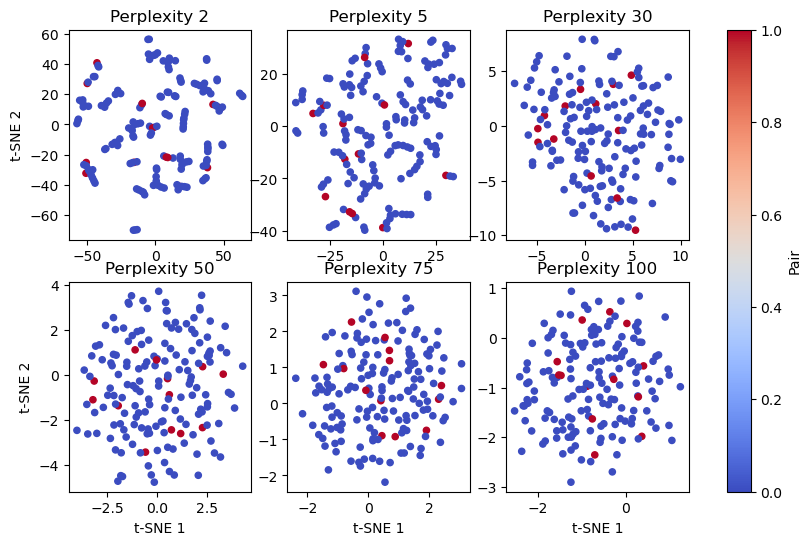

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
perplexities = [2, 5, 30, 50, 75, 100]
for idx, ax in enumerate(axes.flatten()):
    tsne = TSNE(n_components=2, random_state=29, perplexity=perplexities[idx])
    embeddings_2d_tsne = tsne.fit_transform(embeddings)
    
    scatter = ax.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1], s=20, c=pair_np, cmap='coolwarm')
    
    if idx in {0,3}:
        ax.set_ylabel('t-SNE 2')
    if idx >= 3:
        ax.set_xlabel('t-SNE 1')
        
    ax.set_title(f'Perplexity {perplexities[idx]}')

cbar = fig.colorbar(scatter, ax=axes)
cbar.set_label('Pair')
plt.show()

### Logistic Regression Classification Testing

In [51]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#### Classifying Pair Label

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, pair_np, test_size=0.3, random_state=29, stratify=pair_np
)

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=29),
    'Random Forest': RandomForestClassifier(random_state=29)
}


In [54]:
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    cv_scores = cross_val_score(clf, embeddings, pair_np, cv=5, scoring='accuracy')
    print(f"5-fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Logistic Regression:
Accuracy: 0.9216
AUC: 0.4309

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        47
           1       0.00      0.00      0.00         4

    accuracy                           0.92        51
   macro avg       0.46      0.50      0.48        51
weighted avg       0.85      0.92      0.88        51

5-fold CV Accuracy: 0.9232 ± 0.0140

Random Forest:
Accuracy: 0.9216
AUC: 0.4521

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        47
           1       0.00      0.00      0.00         4

    accuracy                           0.92        51
   macro avg       0.46      0.50      0.48        51
weighted avg       0.85      0.92      0.88        51

5-fold CV Accuracy: 0.9232 ± 0.0140


#### Classifying Suited

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, suited_np, test_size=0.3, random_state=29, stratify=suited_np
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=29),
    'Random Forest': RandomForestClassifier(random_state=29)
}


In [56]:
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    cv_scores = cross_val_score(clf, embeddings, suited_np, cv=5, scoring='accuracy')
    print(f"5-fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Logistic Regression:
Accuracy: 0.4706
AUC: 0.5170

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        27
           1       0.43      0.38      0.40        24

    accuracy                           0.47        51
   macro avg       0.46      0.47      0.46        51
weighted avg       0.47      0.47      0.47        51

5-fold CV Accuracy: 0.4795 ± 0.0556

Random Forest:
Accuracy: 0.6078
AUC: 0.5363

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        27
           1       0.62      0.42      0.50        24

    accuracy                           0.61        51
   macro avg       0.61      0.60      0.59        51
weighted avg       0.61      0.61      0.59        51

5-fold CV Accuracy: 0.5087 ± 0.0765


### Cosine Similarity

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
from constants import HOLE_CARD_DICT

In [59]:
unique_hands = df.hand.str[:2].unique()

In [60]:
similarity_matrix = pd.DataFrame(cosine_similarity(embeddings))

In [61]:
similarity_matrix.columns = [HOLE_CARD_DICT[i] for i in similarity_matrix.columns]
similarity_matrix.set_index(keys=pd.Index([HOLE_CARD_DICT[i] for i in range(169)]), inplace=True)

In [62]:
similarity_matrix['AKo'].sort_values()

AKs   -0.824273
A7o   -0.690814
KTo   -0.684533
AJo   -0.672374
A9o   -0.663046
         ...   
Q5s    0.615986
97s    0.633006
98o    0.644306
J7s    0.662423
AKo    1.000000
Name: AKo, Length: 169, dtype: float32

In [63]:
print("Suited to Non-Suited Similarity")
for hand in unique_hands:
    if hand[0] != hand[1]:
        print(hand," Similarity: ", similarity_matrix[f'{hand}o'][f'{hand}s'])

Suited to Non-Suited Similarity
32  Similarity:  -0.08694213
42  Similarity:  -0.74823457
43  Similarity:  0.21788184
52  Similarity:  0.20095153
53  Similarity:  -0.6760636
54  Similarity:  -0.7627276
62  Similarity:  0.025034504
63  Similarity:  -0.59288675
64  Similarity:  0.3389115
65  Similarity:  0.20267518
72  Similarity:  -0.40061915
73  Similarity:  0.33640936
74  Similarity:  0.34962523
75  Similarity:  0.35493267
76  Similarity:  -0.30173442
82  Similarity:  0.4171199
83  Similarity:  -0.16744837
84  Similarity:  -0.3243608
85  Similarity:  0.06668195
86  Similarity:  -0.7190226
87  Similarity:  0.09460688
92  Similarity:  -0.40580708
93  Similarity:  -0.50733906
94  Similarity:  -0.060033195
95  Similarity:  0.15490411
96  Similarity:  0.2682067
97  Similarity:  -0.15199427
98  Similarity:  -0.2794893
A2  Similarity:  -0.2747264
A3  Similarity:  0.1562308
A4  Similarity:  0.15045942
A5  Similarity:  -0.28904223
A6  Similarity:  -0.22149146
A7  Similarity:  -0.11323848
A8  S

### From Suited to Non-suited Embedding Directions

In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
suited_hands = embeddings[df['suited'] == 1]
offsuit_hands = embeddings[df['suited'] == 0]

suited_indices = np.where(df['suited'] == 1)[0]
offsuit_indices = np.where(df['suited'] == 0)[0]

In [66]:
suited_offsuit_pairs = []
for s_idx in suited_indices:
    s_hand_ranks = df.iloc[s_idx]['hand'][:2]
    for o_idx in offsuit_indices:
        o_hand_ranks = df.iloc[o_idx]['hand'][:2]
        if s_hand_ranks == o_hand_ranks:
            suited_offsuit_pairs.append((s_idx, o_idx))

In [67]:
suitedness_vectors = []
for s_idx, o_idx in suited_offsuit_pairs:
    suitedness_vectors.append(embeddings[s_idx] - embeddings[o_idx])

avg_suitedness_vector = np.mean(suitedness_vectors, axis=0)

In [68]:
similarities = []
for vec in suitedness_vectors:
    sim = cosine_similarity([vec], [avg_suitedness_vector])[0][0]
    similarities.append(sim)

# If similarities are consistently high, the direction is consistent
print(f"Average cosine similarity: {np.mean(similarities):.4f}")
print(f"Standard deviation: {np.std(similarities):.4f}")

Average cosine similarity: 0.0633
Standard deviation: 0.3362


In [69]:
test_idx = 1  # Index of a test pair
s_idx, o_idx = suited_offsuit_pairs[test_idx]

# Predict the suited embedding by adding the average suitedness vector
predicted_suited = embeddings[o_idx] + avg_suitedness_vector

# Compare to the actual suited embedding
actual_suited = embeddings[s_idx]

In [70]:
mse = mean_squared_error(actual_suited, predicted_suited)
cos_sim = cosine_similarity([actual_suited], [predicted_suited])[0][0]

print(f"MSE between predicted and actual: {mse:.4f}")
print(f"Cosine similarity: {cos_sim:.4f}")

MSE between predicted and actual: 4.3388
Cosine similarity: -0.7241
